In [40]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from get_metrics import *
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

print("Libraries imported")

Libraries imported


In [2]:
datadir = '/content/drive/MyDrive/Project/Dataset'
trainingset = datadir+'/train/'
testingset = datadir+'/test/'

img_size = (320,320)
batch_size = 8

The following mean and std are computed by preloading the dataset not-normalized and will be used to regularly normalize the dataset from now on.

In [ ]:
def get_mean_std(loader):
  # VAR[X] = E[X**2] - E[X]**2
  channels_sum, channels_squared_sum, num_batches = 0, 0, 0
  
  for data, _ in loader:
    channels_sum += torch.mean(data, dim=[0,2,3])
    channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
    num_batches +=1

  mean = channels_sum/num_batches
  std = (channels_squared_sum/num_batches - mean**2)**0.5

  return mean, std

#mean1, std1 = get_mean_std(dataloaders['train'])
#mean2, std2 = get_mean_std(dataloaders['test'])
#print("mean_train=",mean1)
#print("std_train=",std1)
#print("mean_test=",mean2)
#print("std_test=",std2)

mean_train= tensor([0.3017, 0.3017, 0.3017])
std_train= tensor([0.1913, 0.1913, 0.1913])
mean_test= tensor([0.3176, 0.3176, 0.3176])
std_test= tensor([0.1881, 0.1881, 0.1881])


In [30]:
mean1, std1 = [0.3017, 0.3017, 0.3017], [0.1913, 0.1913, 0.1913]
mean2, std2 = [0.3176, 0.3176, 0.3176], [0.1881, 0.1881, 0.1881]

data_transforms = {
    'train': transforms.Compose([
                                 transforms.Resize(img_size),
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomRotation(10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = mean1, 
                                                  std = std1)
    ]),
    'test': transforms.Compose([
                                transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = mean2, 
                                                  std = std2)
    ]),
                   }

print("Initializing Datasets and Dataloaders...\n")

image_datasets = {'train' : datasets.ImageFolder(trainingset, data_transforms['train']), 
                  'test' : datasets.ImageFolder(testingset, data_transforms['test'])}

dataloaders = {'train' : torch.utils.data.DataLoader(image_datasets['train'], 
                                                     batch_size = batch_size, shuffle = True,
                                                     num_workers=4, pin_memory=True),
               'test' : torch.utils.data.DataLoader(image_datasets['test'], 
                                                     batch_size = batch_size, shuffle = True,
                                                     num_workers=4, pin_memory=True)}

device = torch.device("cuda:0")
dataset_sizes = {'train' : len(image_datasets['train']),
                 'test' : len(image_datasets['test'])}
print("Initialized!")

Initializing Datasets and Dataloaders...

Initialized!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [31]:
# Class names convert to index
image_datasets['train'].class_to_idx
class_names=image_datasets['train'].classes
print(">>Class Names: {}\n".format(image_datasets['train'].classes))
print(">>Class Index: {}\n".format(image_datasets['train'].class_to_idx))
print(">>Number of images in training={}\n".format(dataset_sizes['train']))
print(">>Number of images in test={}\n".format(dataset_sizes['test']))
print("    Number of steps for training set={}\n".format(len(dataloaders['train'])))
print("    Number of steps for test set={}\n".format(len(dataloaders['test']))) 

>>Class Names: ['abnormal', 'normal']

>>Class Index: {'abnormal': 0, 'normal': 1}

>>Number of images in training=8379

>>Number of images in test=563

    Number of steps for training set=1048

    Number of steps for test set=71



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


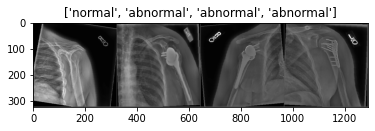

In [32]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(mean1)
    std = np.array(std1)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
inputs = [inputs[x] for x in [0,1,2,3]]
classes = [classes[x] for x in [0,1,2,3]]
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

**Trainining the models**

In [33]:
train_losses = []
train_acc = []
test_losses = []
test_acc = []

In [34]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_weights = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  ghost=True
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-'*10)

    for phase in ['train', 'test']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        #forward, track history only if we are in training
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          #backward + optimize only if we are in training
          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.detach() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss/dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      #storing losses and accuracy per epochs to plot metrics graph

      if phase == 'train':
        train_losses.append(epoch_loss)
        train_acc.append(epoch_acc)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      if phase == 'test':
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        test_losses.append(epoch_loss)
        test_acc.append(epoch_acc)
      torch.cuda.empty_cache()


      #deep copy the model
      if phase == 'test' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_weights = copy.deepcopy(model.state_dict())
    
    print()
    torch.cuda.empty_cache()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
  print('Best val Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model_weights)
  torch.save(best_model_weights, "./model.pth")
  return model


**Densenet169**

In [35]:
model_ft = models.densenet169(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Sequential(nn.Linear(num_ftrs, 2), nn.Sigmoid())

model_ft = model_ft.to(device)

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), betas = (0.9, 0.999), lr=0.0001)
#decay of LR
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [37]:
model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler,40)

Epoch 0/39
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5897 Acc: 0.7046
train Loss: 0.5897 Acc: 0.7046
test Loss: 0.5250 Acc: 0.7726
test Loss: 0.5250 Acc: 0.7726

Epoch 1/39
----------
train Loss: 0.5549 Acc: 0.7456
train Loss: 0.5549 Acc: 0.7456
test Loss: 0.5599 Acc: 0.7407
test Loss: 0.5599 Acc: 0.7407

Epoch 2/39
----------
train Loss: 0.5455 Acc: 0.7580
train Loss: 0.5455 Acc: 0.7580
test Loss: 0.5035 Acc: 0.7993
test Loss: 0.5035 Acc: 0.7993

Epoch 3/39
----------
train Loss: 0.5385 Acc: 0.7658
train Loss: 0.5385 Acc: 0.7658
test Loss: 0.5317 Acc: 0.7798
test Loss: 0.5317 Acc: 0.7798

Epoch 4/39
----------
train Loss: 0.5342 Acc: 0.7691
train Loss: 0.5342 Acc: 0.7691
test Loss: 0.5094 Acc: 0.7922
test Loss: 0.5094 Acc: 0.7922

Epoch 5/39
----------
train Loss: 0.5278 Acc: 0.7719
train Loss: 0.5278 Acc: 0.7719
test Loss: 0.5158 Acc: 0.7815
test Loss: 0.5158 Acc: 0.7815

Epoch 6/39
----------
train Loss: 0.5152 Acc: 0.7884
train Loss: 0.5152 Acc: 0.7884
test Loss: 0.5206 Acc: 0.7815
test Loss: 0.5206 Acc: 0.7815

Epoch 7

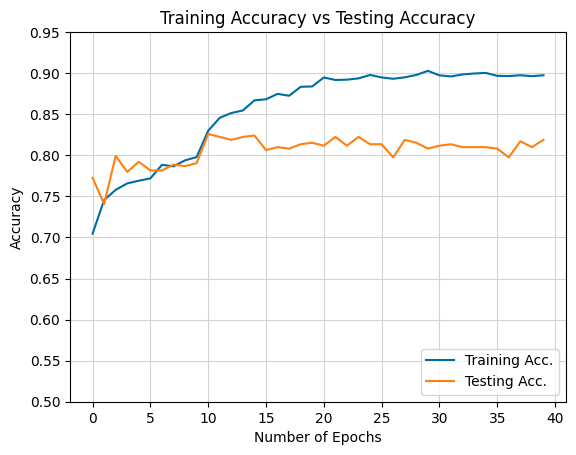

In [42]:
matplotlib.rcdefaults()
epochs=range(0, 40, 1)
plt.plot(epochs, train_acc, color='#006BA4')
plt.plot(epochs, test_acc, color='#FF800E')
plt.grid(b=True, which='major', color='lightgray')
plt.grid(b=True, which='minor', color='lightgray')
plt.xticks(np.arange(0, 45, 5))
plt.yticks(np.arange(0.5, 1, 0.05))
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 600
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Testing Accuracy")
plt.legend(['Training Acc.', 'Testing Acc.'],loc='lower right')

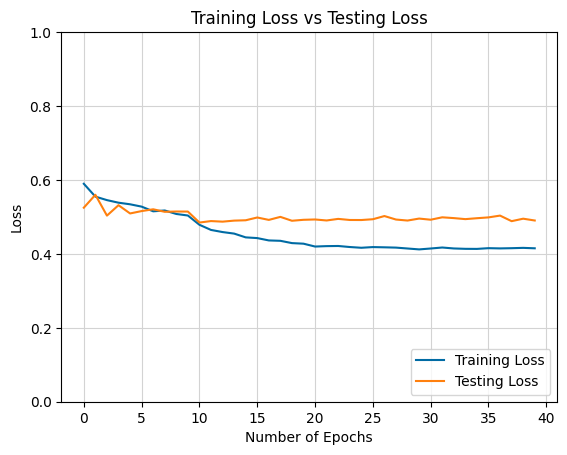

In [43]:
#This code block draw graph for loss
matplotlib.rcdefaults()
plt.plot(epochs, train_losses, color='#006BA4')
plt.plot(epochs, test_losses, color='#FF800E')
plt.grid(b=True, which='major', color='lightgray')
plt.grid(b=True, which='minor', color='lightgray')
plt.xticks(np.arange(0, 45, 5))
plt.yticks(np.arange(0, 1.2, 0.2))
plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Testing Loss")
plt.legend(['Training Loss', 'Testing Loss'],loc='lower right')

In [45]:
get_metric.test_model(model_ft,device,dataloaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Correct Prediction: 465  Total Images: 563
Test Accuracy = 0.825933


In [47]:
actuals, predictions = get_metric.test_label_predictions(model_ft, device, dataloaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [48]:
get_metric.get_classification_report(actuals, predictions)

Classification Report :
               precision    recall  f1-score   support

           0       0.85      0.78      0.82       278
           1       0.80      0.87      0.83       285

    accuracy                           0.83       563
   macro avg       0.83      0.83      0.83       563
weighted avg       0.83      0.83      0.83       563



Confusion matrix:
 [[218  60]
 [ 38 247]]


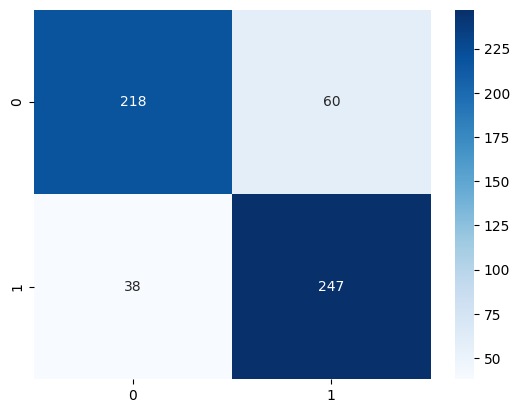

In [49]:
get_metric.get_confusion_matrix(actuals, predictions)

In [50]:
get_metric.get_cohen_kappa(actuals, predictions)

Kappa Score of this model:
 0.6514724647202254


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Auc Score For Each Class:  {0: 0.878177458033573, 1: 0.8755458790862047}


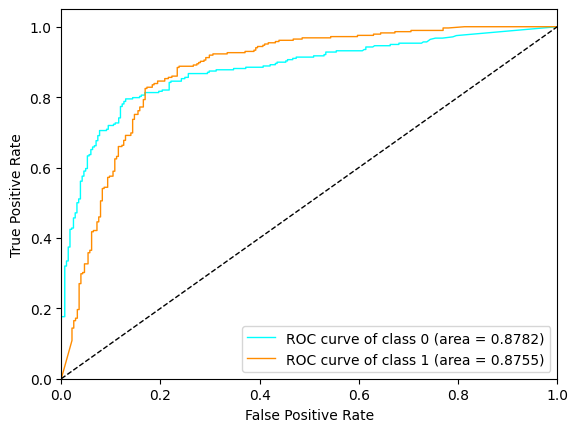

In [51]:
get_metric.get_roc_curves(model_ft, device,  dataloaders['test'])